<a href="https://colab.research.google.com/github/Hector94X/UCM_intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

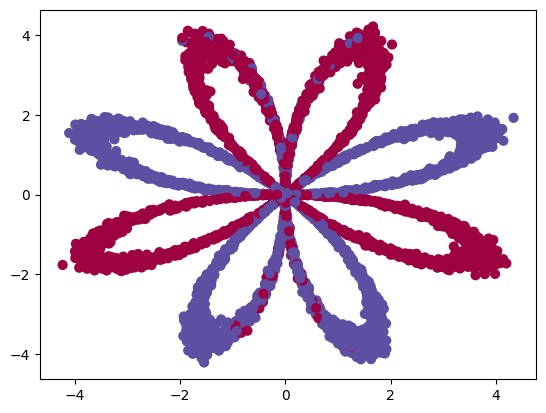

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [7]:
## X first example
X[0,:]

array([3.73636263, 1.70623832])

In [8]:
## Y firsts examples
y[:8]

array([1, 0, 1, 0, 1, 0, 1, 0], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

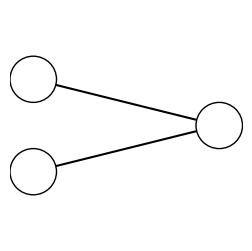

In [37]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [38]:
model = keras.Sequential() # HOV: para instanciar el modelo
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

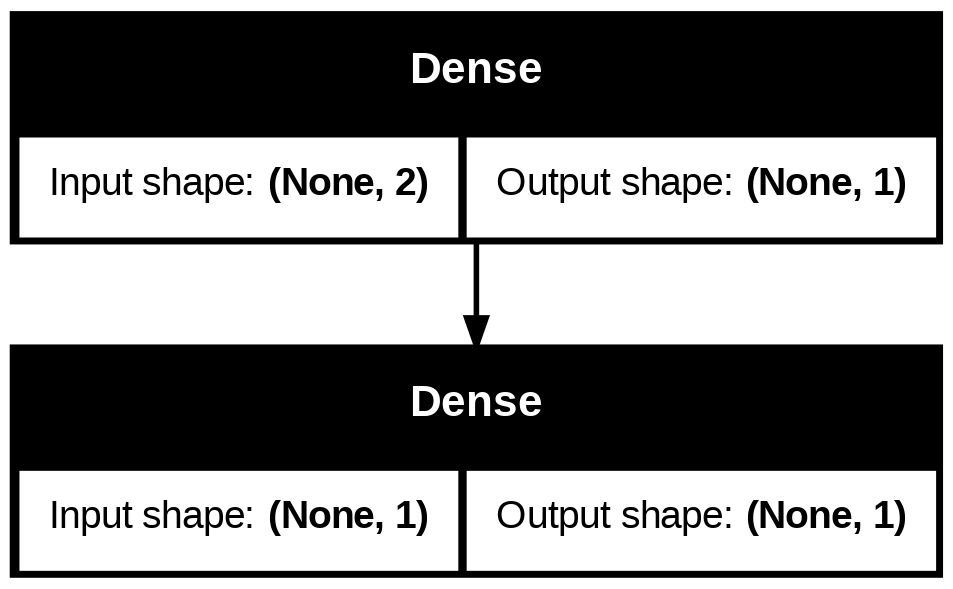

In [39]:
from tensorflow.keras.utils import plot_model


model2 = keras.Sequential()
model2.add(keras.Input(shape=(2,)))  # Define input shape with an Input layer
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.summary()
plot_model(model2, show_shapes=True)


model2.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))
model2.summary()

plot_model(model2, show_shapes=True)

In [40]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

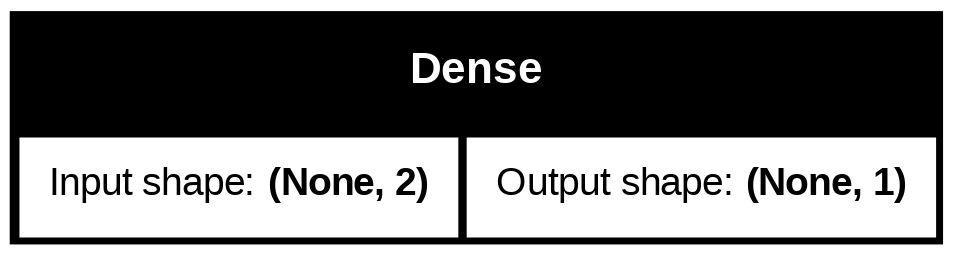

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [42]:
# definir los parámetros base del modelo de Deep Learning (DL)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [43]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5075 - loss: 0.6541 - val_accuracy: 0.4850 - val_loss: 0.6604
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4837 - loss: 0.6560 - val_accuracy: 0.4625 - val_loss: 0.6590
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4590 - loss: 0.6620 - val_accuracy: 0.4600 - val_loss: 0.6590
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4594 - loss: 0.6643 - val_accuracy: 0.4588 - val_loss: 0.6591
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4610 - loss: 0.6633 - val_accuracy: 0.4588 - val_loss: 0.6595
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4674 - loss: 0.6616 - val_accuracy: 0.4600 - val_loss: 0.6595
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4647 - loss: 0.6610 - val_accuracy: 0.4600 - val_loss: 0.6596
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4586 - loss: 0.6633 - val_accuracy: 0.

#### Making predictions

In [44]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6551375985145569
Test Accuracy: 0.47699999809265137


In [45]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(array([[0.525316  ],
        [0.49875712],
        [0.605014  ]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

32860/32860 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step


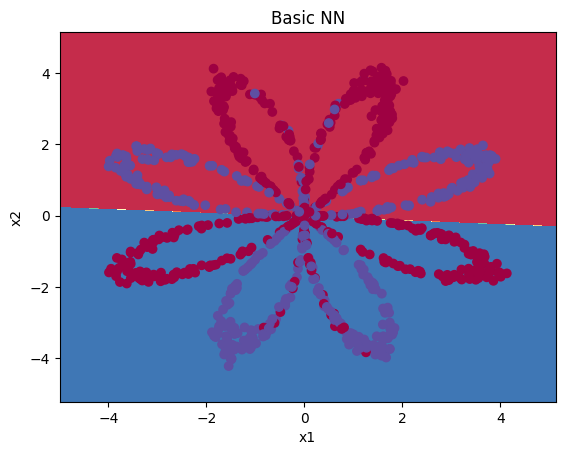

In [46]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

draw_neural_net(.1, .9, .1, .9, [3, 5, 4, 2]) 

draw_neural_net(.1, .1, .1, .9, [3, 5, 4, 2])

draw_neural_net(.1, .1, .1, .1, [3, 5, 4, 2])

draw_neural_net(.9, .9, .1, .9, [3, 5, 4, 2])

draw_neural_net(.9, .9, .9, .9, [3, 5, 4, 2])

draw_neural_net(.9, .1, .9, .9, [3, 5, 4, 2])

draw_neural_net(.9, .1, .9, .1, [3, 5, 4, 2])


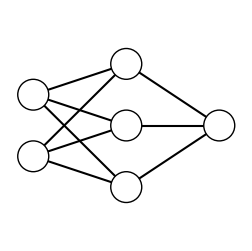

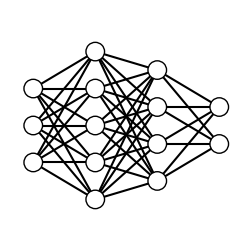

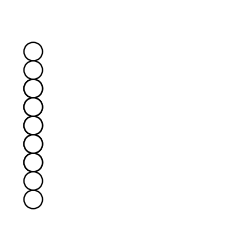

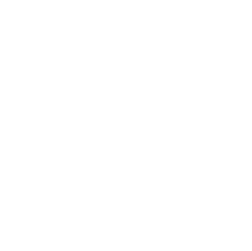

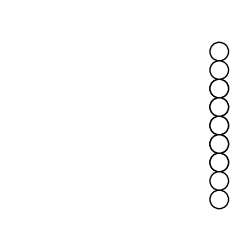

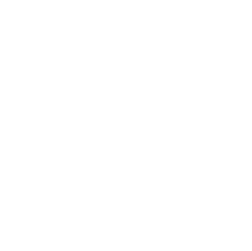

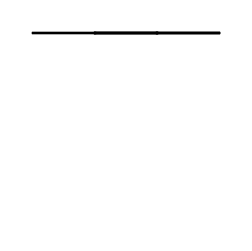

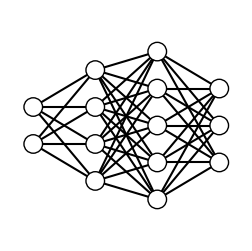

In [47]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

# 1
print("draw_neural_net(.1, .9, .1, .9, [3, 5, 4, 2]) ")
draw_neural_net(.1, .9, .1, .9, [3, 5, 4, 2])
# 2
print()
print("draw_neural_net(.1, .1, .1, .9, [3, 5, 4, 2])")
draw_neural_net(.1, .1, .1, .9, [3, 5, 4, 2])
# 3
print()
print("draw_neural_net(.1, .1, .1, .1, [3, 5, 4, 2])")
draw_neural_net(.1, .1, .1, .1, [3, 5, 4, 2])
# 4
print()
print("draw_neural_net(.9, .9, .1, .9, [3, 5, 4, 2])")
draw_neural_net(.9, .9, .1, .9, [3, 5, 4, 2])
# 5
print()
print("draw_neural_net(.9, .9, .9, .9, [3, 5, 4, 2])")
draw_neural_net(.9, .9, .9, .9, [3, 5, 4, 2])
# 6
print()
print("draw_neural_net(.9, .1, .9, .9, [3, 5, 4, 2])")
draw_neural_net(.9, .1, .9, .9, [3, 5, 4, 2])
# 7
print()
print("draw_neural_net(.9, .1, .9, .1, [3, 5, 4, 2])")
draw_neural_net(.9, .1, .9, .1, [3, 5, 4, 2])

In [48]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

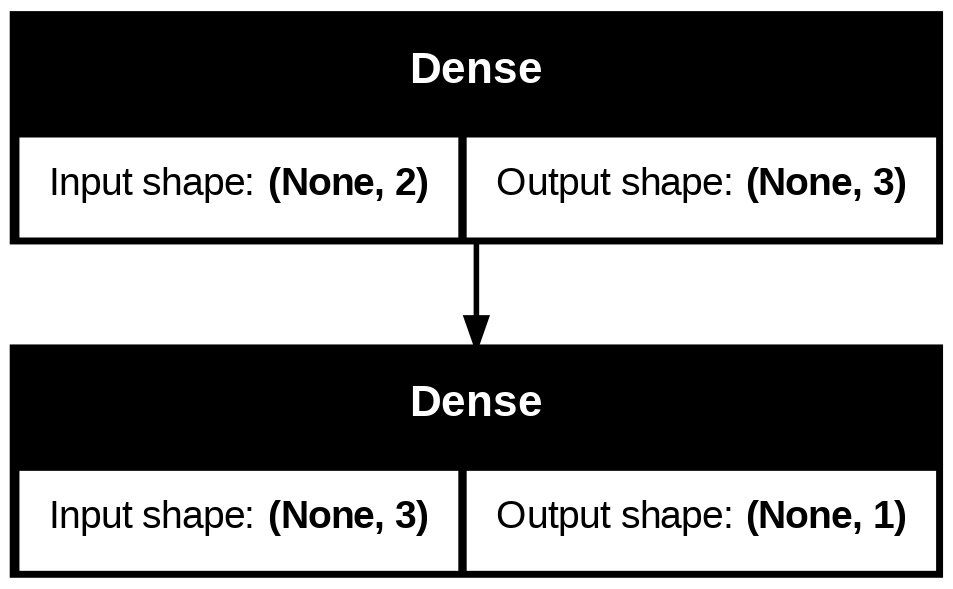

In [49]:
plot_model(model, show_shapes=True)

In [50]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5670 - loss: 0.6785 - val_accuracy: 0.6350 - val_loss: 0.6604
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5916 - loss: 0.6702 - val_accuracy: 0.6288 - val_loss: 0.6566
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 0.6690 - val_accuracy: 0.6212 - val_loss: 0.6531
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5998 - loss: 0.6548 - val_accuracy: 0.6212 - val_loss: 0.6489
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5886 - loss: 0.6558 - val_accuracy: 0.6263 - val_loss: 0.6444
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6518 - val_accuracy: 0.6300 - val_loss: 0.6400
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5922 - loss: 0.6471 - val_accuracy: 0.6338 - val_loss: 0.6353
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5975 - loss: 0.6457 - val_accuracy: 0.

In [51]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5774462223052979
Test Accuracy: 0.593999981880188


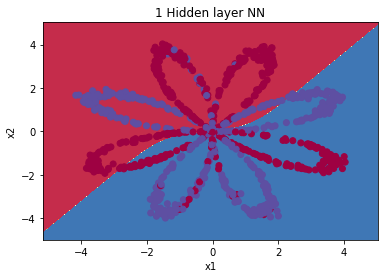

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 1.6553 - accuracy: 0.3232 - val_loss: 1.2819 - val_accuracy: 0.3438
Epoch 2/25
100/100 [==============================] - 0s 1ms/step - loss: 1.2996 - accuracy: 0.3212 - val_loss: 1.0735 - val_accuracy: 0.3487
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 1.1023 - accuracy: 0.3268 - val_loss: 0.9237 - val_accuracy: 0.3713
Epoch 4/25
100/100 [==============================] - 0s 1ms/step - loss: 0.9496 - accuracy: 0.3311 - val_loss: 0.8131 - val_accuracy: 0.4338
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.8156 - accuracy: 0.4076 - val_loss: 0.7370 - val_accuracy: 0.5063
Epoch 6/25
100/100 [==============================] - 0s 1ms/step - loss: 0.7245 - accuracy: 0.5166 - val_loss: 0.6977 - val_accuracy: 0.6087
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.6330 - val_loss: 0.6846 - val_accuracy: 0.6250
Epoch 

Test Loss: 0.6600703001022339
Test Accuracy: 0.46000000834465027


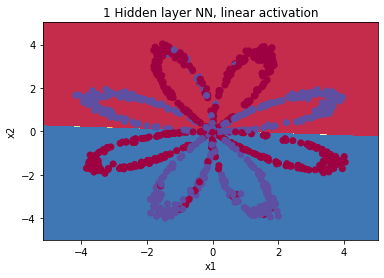

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

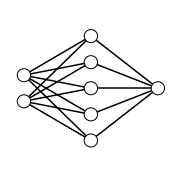

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [ ]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(16, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 2ms/step - loss: 0.6684 - accuracy: 0.6390 - val_loss: 0.6719 - val_accuracy: 0.6062
Epoch 2/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6627 - accuracy: 0.6222 - val_loss: 0.6682 - val_accuracy: 0.5500
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6485 - accuracy: 0.5809 - val_loss: 0.6645 - val_accuracy: 0.5487
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.5673 - val_loss: 0.6612 - val_accuracy: 0.5350
Epoch 5/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6432 - accuracy: 0.5621 - val_loss: 0.6563 - val_accuracy: 0.5425
Epoch 6/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6378 - accuracy: 0.5709 - val_loss: 0.6522 - val_accuracy: 0.5375
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6277 - accuracy: 0.5602 - val_loss: 0.6475 - val_accuracy: 0.5350
Epoch 

Test Loss: 0.4857807457447052
Test Accuracy: 0.8059999942779541


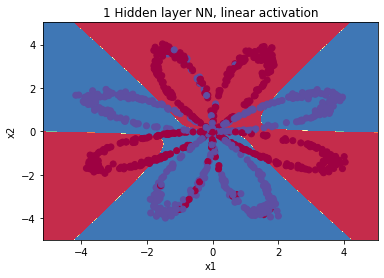

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

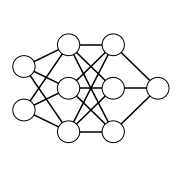

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [ ]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(4, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(4, activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 3ms/step - loss: 0.7504 - accuracy: 0.5043 - val_loss: 0.7147 - val_accuracy: 0.4925
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.5020 - val_loss: 0.6960 - val_accuracy: 0.4925
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5053 - val_loss: 0.6901 - val_accuracy: 0.5825
Epoch 4/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.6004 - val_loss: 0.6873 - val_accuracy: 0.6338
Epoch 5/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6862 - accuracy: 0.6377 - val_loss: 0.6849 - val_accuracy: 0.6237
Epoch 6/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.6546 - val_loss: 0.6826 - val_accuracy: 0.6250
Epoch 7/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6777 - accuracy: 0.6513 - val_loss: 0.6798 - val_accuracy: 0.6313
Epoch 

Test Loss: 0.5937795639038086
Test Accuracy: 0.6299999952316284


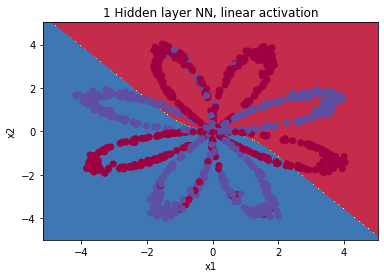

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.4183 - val_loss: 0.6885 - val_accuracy: 0.6237
Epoch 2/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.6680 - val_loss: 0.6690 - val_accuracy: 0.6500
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6611 - accuracy: 0.6664 - val_loss: 0.6555 - val_accuracy: 0.6400
Epoch 4/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6427 - accuracy: 0.6676 - val_loss: 0.6475 - val_accuracy: 0.6400
Epoch 5/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6344 - accuracy: 0.6581 - val_loss: 0.6416 - val_accuracy: 0.6425
Epoch 6/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6265 - accuracy: 0.6608 - val_loss: 0.6368 - val_accuracy: 0.6425
Epoch 7/25
100/100 [==============================] - 0s 1ms/step - loss: 0.6259 - accuracy: 0.6484 - val_loss: 0.6319 - val_accuracy: 0.6413
Epoch 

Test Loss: 0.5625403523445129
Test Accuracy: 0.5860000252723694


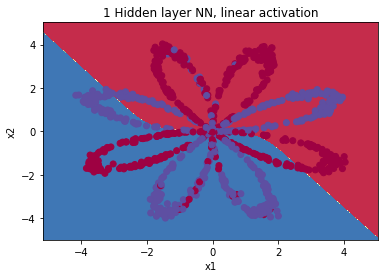

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

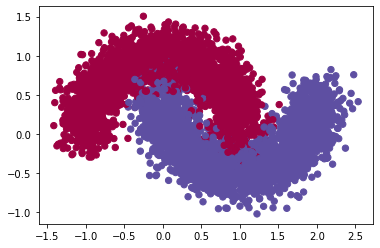

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(16, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(16, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 1s 4ms/step - loss: 0.6852 - accuracy: 0.4676 - val_loss: 0.4654 - val_accuracy: 0.8120
Epoch 2/35
47/47 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8031 - val_loss: 0.3655 - val_accuracy: 0.8400
Epoch 3/35
47/47 [==============================] - 0s 2ms/step - loss: 0.3806 - accuracy: 0.8274 - val_loss: 0.3240 - val_accuracy: 0.8573
Epoch 4/35
47/47 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.8583 - val_loss: 0.3021 - val_accuracy: 0.8760
Epoch 5/35
47/47 [==============================] - 0s 2ms/step - loss: 0.3197 - accuracy: 0.8601 - val_loss: 0.2917 - val_accuracy: 0.8773
Epoch 6/35
47/47 [==============================] - 0s 2ms/step - loss: 0.3123 - accuracy: 0.8639 - val_loss: 0.2873 - val_accuracy: 0.8773
Epoch 7/35
47/47 [==============================] - 0s 2ms/step - loss: 0.2994 - accuracy: 0.8699 - val_loss: 0.2850 - val_accuracy: 0.8733
Epoch 8/35
47/47 [==

Test Loss: 0.12208694219589233
Test Accuracy: 0.9584000110626221


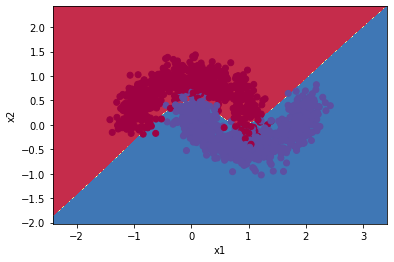

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

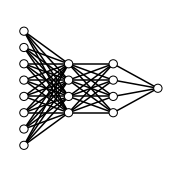

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
layer_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
layer_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 5         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

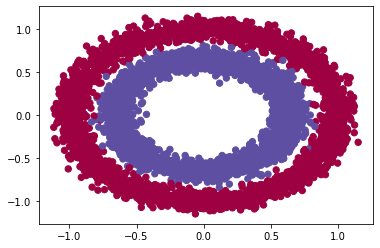

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(32, activation='relu')(inputs)
l_2 = layers.Dense(32, activation='relu')(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid')(l_2)


model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 1s 5ms/step - loss: 0.6818 - accuracy: 0.5041 - val_loss: 0.6617 - val_accuracy: 0.4933
Epoch 2/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.5221 - val_loss: 0.6171 - val_accuracy: 0.6280
Epoch 3/35
47/47 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.7203 - val_loss: 0.5389 - val_accuracy: 0.8253
Epoch 4/35
47/47 [==============================] - 0s 2ms/step - loss: 0.5032 - accuracy: 0.9080 - val_loss: 0.4167 - val_accuracy: 0.9760
Epoch 5/35
47/47 [==============================] - 0s 2ms/step - loss: 0.3718 - accuracy: 0.9888 - val_loss: 0.2838 - val_accuracy: 0.9893
Epoch 6/35
47/47 [==============================] - 0s 2ms/step - loss: 0.2559 - accuracy: 0.9923 - val_loss: 0.1861 - val_accuracy: 0.9947
Epoch 7/35
47/47 [==============================] - 0s 3ms/step - loss: 0.1683 - accuracy: 0.9965 - val_loss: 0.1302 - val_accuracy: 0.9947
Epoch 8/35
47/47 [==

Test Loss: 0.00950197409838438
Test Accuracy: 0.9991999864578247


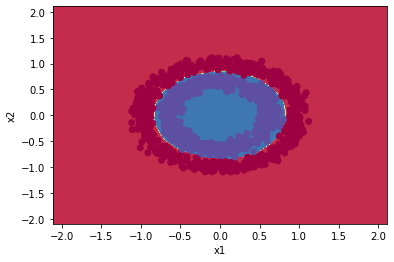

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)